In [1]:
import functools
import json
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Generate Training and Test Data

The true function that we would like to fit using our neural network is a superposition of 5 sine waves of different frequencies. The resulting function $f_\text{true}$ is a smooth odd function. Our training data has added Gaussian noise $y = f_\text{true}(x) + \epsilon,\, \epsilon \sim \mathcal{N}(0, \sigma^2)$. The test data is noise-free.

In [2]:
# Define the true function

np.random.seed(0)
F_TRUE_PARAMS = np.random.rand(5) * 2.0 - 1.0

def f_true(x):
    m = F_TRUE_PARAMS.shape[0]
    return (np.sin(x[:, None] * np.arange(m)[None, :] * math.pi) * F_TRUE_PARAMS).sum(axis=-1)

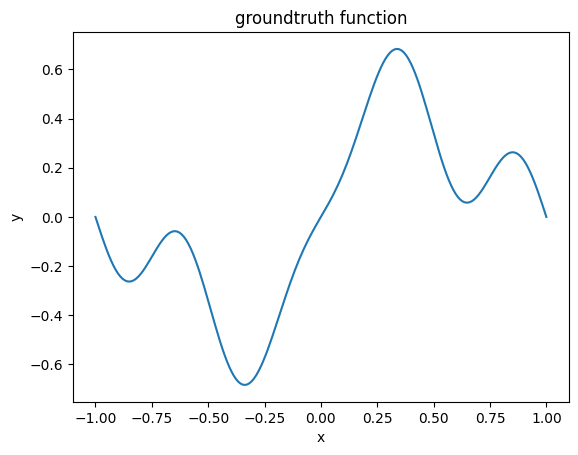

In [3]:
plt.figure()
plt.plot(np.linspace(-1, 1, 200), f_true(np.linspace(-1, 1, 200)))
plt.title("groundtruth function")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

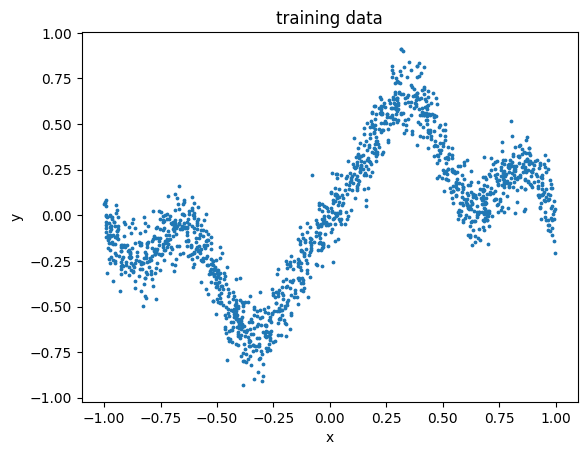

In [4]:
# Generate noisy training data
np.random.seed(10)
TRAIN_N = 1500
TRAIN_SIGMA = 0.1
train_x = np.random.uniform(low=-1.0, high=1.0, size=TRAIN_N)
train_y = f_true(train_x) + np.random.randn(TRAIN_N) * TRAIN_SIGMA

plt.figure()
plt.scatter(train_x, train_y, s=3)
plt.title("training data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [5]:
# Generate noiseless test data
np.random.seed(10)
TEST_N = 500
test_x = np.linspace(-1, 1, TEST_N)
test_y = f_true(test_x)

## Simple Neural Network and Visualization

This section is a simplified version of what you’ve done in the homework 1.
We train a 1-hidden layer neural network using Stochastic Gradient Descent with Momentum.

In [6]:
def train_model(model, n_steps, batch_size, lr, seed, train_x=train_x, train_y=train_y):
    np.random.seed(seed)
    torch.manual_seed(seed)
    log_interval = 10
    eval_interval = int(TRAIN_N / batch_size) + 1
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
    criterion = nn.MSELoss()
    all_indices = []
    while len(all_indices) < n_steps * batch_size:
        all_indices.append(np.random.permutation(TRAIN_N))
    all_indices = np.concatenate(all_indices)
    for step in range(n_steps):
        indices = all_indices[step * batch_size: step * batch_size + batch_size]
        batch_x = torch.from_numpy(train_x[indices]).float().unsqueeze(-1)
        batch_y = torch.from_numpy(train_y[indices]).float()
        pred = model(batch_x).view(-1)
        loss = criterion(batch_y, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (step + 1) % log_interval == 0:
            print(json.dumps({"step": step, "train_loss": loss.item()}))
        if (step + 1) % eval_interval == 0 or step + 1 == n_steps:
            with torch.no_grad():
                batch_x = torch.from_numpy(test_x).float().unsqueeze(-1)
                batch_y = torch.from_numpy(test_y).float()
                pred = model(batch_x).view(-1)
                loss = criterion(batch_y, pred)
                print(json.dumps({"step": step, "test_loss": loss.item()}))
    return model, batch_x.view(-1).numpy(), pred.numpy()

{"step": 9, "train_loss": 0.11429977416992188}
{"step": 19, "train_loss": 0.10348392277956009}
{"step": 29, "train_loss": 0.16306805610656738}
{"step": 39, "train_loss": 0.06847310066223145}
{"step": 46, "test_loss": 0.05129111185669899}
{"step": 49, "train_loss": 0.03928583115339279}
{"step": 59, "train_loss": 0.05319014564156532}
{"step": 69, "train_loss": 0.04406897351145744}
{"step": 79, "train_loss": 0.045208804309368134}
{"step": 89, "train_loss": 0.027133958414196968}
{"step": 93, "test_loss": 0.016161637380719185}
{"step": 99, "train_loss": 0.032674774527549744}
{"step": 109, "train_loss": 0.014737807214260101}
{"step": 119, "train_loss": 0.03610832244157791}
{"step": 129, "train_loss": 0.024262163788080215}
{"step": 139, "train_loss": 0.017517831176519394}
{"step": 140, "test_loss": 0.018632497638463974}
{"step": 149, "train_loss": 0.02990102209150791}
{"step": 159, "train_loss": 0.04019859805703163}
{"step": 169, "train_loss": 0.01481915358453989}
{"step": 179, "train_loss": 

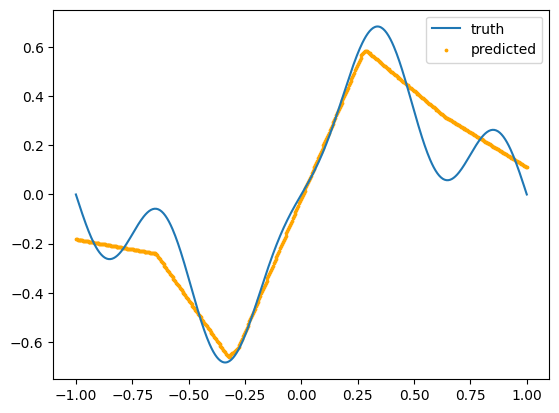

In [9]:
# Train a neural network with 1 hidden layer

width = 20
lr = 0.1
batch_size = 32
n_steps = int(TRAIN_N / batch_size * 10)

np.random.seed(100)
torch.manual_seed(100)

model = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, 1)
)

model, evaluated_x, evaluated_pred = train_model(model, n_steps, batch_size, lr, 150)

plt.figure()
plt.plot(test_x, f_true(test_x), label="truth")
plt.scatter(evaluated_x, evaluated_pred, s=3, c='orange', label="predicted")
plt.legend()
plt.show()

The neural network's training on the data resulted in a learned function, however, its performance is not optimal due to the limited representational power of a single layer. To overcome this, the next section will train a deeper neural network for improved fitting of the true function. But before that, let's first visualize this model using local linearization. Here is the first-order Talor expansion of the learned function $f$ w.r.t. the neural network parameters $\mathbf{w}$:

$$f(x,\mathbf{w}') \approx f(x,\mathbf{w}) + \langle \nabla_\mathbf{w} f(x, \mathbf{w}) |_\mathbf{w} , \mathbf{w}' - \mathbf{w}\rangle$$

Let's first visualize $\nabla_\mathbf{w} f(\cdot, \mathbf{w}) |_\mathbf{w}$.
For each single $x$,
$\nabla_\mathbf{w} f(x, \mathbf{w}) |_\mathbf{w}$ is a vector in $\mathbb{R}^m$,
where $m$ is the number of parameters of the neural network.
So given $n$ datapoints in the training dataset,
we stack these $m$-dim vectors together,
and get a matrix with size $n$ by $m$:

$$
\begin{pmatrix}f(x_1,\mathbf{w}') \\ \vdots \\ f(x_n,\mathbf{w}')\end{pmatrix} =
\begin{pmatrix}f(x_1,\mathbf{w}) \\ \vdots \\ f(x_n,\mathbf{w})\end{pmatrix} +
\begin{pmatrix}\nabla_\mathbf{w} f(x_1, \mathbf{w}) |_\mathbf{w}^T \\ \vdots \\ \nabla_\mathbf{w} f(x_n, \mathbf{w}) |_\mathbf{w}^T\end{pmatrix}(\mathbf{w}' - \mathbf{w})
$$


After that,
we can decompose this matrix with SVD:

$$
\begin{pmatrix}f(x_1,\mathbf{w}') \\ \vdots \\ f(x_n,\mathbf{w}')\end{pmatrix} =
\begin{pmatrix}f(x_1,\mathbf{w}) \\ \vdots \\ f(x_n,\mathbf{w})\end{pmatrix} +
\mathbf{U\Sigma V}^T(\mathbf{w}' - \mathbf{w})
$$

Notice that $\mathbf{V}$ is an orthogonal matrix.

Let's imagine that we have a generalized linear model with a feature matrix corresponding to the linearized features corresponding to each learnable parameter. The singular value and principal features of this matrix is important to us. Here is a visualization of singular values and principal features (rows of $\mathbf{U\Sigma})$:

In [10]:
def svd_local_linearization(model):
    all_grads = []
    for idx in range(TRAIN_N):
        batch_x = torch.from_numpy(train_x[idx: idx + 1]).float().unsqueeze(-1)
        pred = model(batch_x).view(-1)
        model.zero_grad()
        pred.backward()
        flattened_grads = []
        for param in model.parameters():
            flattened_grads.append(param.grad.view(-1).data.numpy())
        flattened_grads = np.concatenate(flattened_grads)
        all_grads.append(flattened_grads)
    all_grads = np.stack(all_grads)
    u, s, vh = np.linalg.svd(all_grads, full_matrices=False)
    principal_feature = u * s
    return all_grads.shape[1], s, principal_feature


def visualize(m, singular_values, principal_feature):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    ax1.bar(np.arange(min(len(singular_values), 20)) + 1, singular_values[:20])
    ax1.set_title("Singular Values (Top-20)")

    for idx in range(min(m, 10)):
        ax2.scatter(train_x, principal_feature[:, idx], s=1,
                    label=("feature " + str(idx + 1) if idx < 2 else None))
    ax2.set_title("Principal Features (Top-10)")
    ax2.set_xlabel("x", labelpad=0)
    ax2.set_ylabel("principal feature", labelpad=0)
    ax2.legend()

    im = ax3.scatter(principal_feature[:, 0], principal_feature[:, 1], c=train_x, s=2)
    ax3.set_title("Top-2 Features (x indicated by color)")
    ax3.set_xlabel("feature 1", labelpad=0)
    ax3.set_ylabel("feature 2", labelpad=0)
    plt.colorbar(im, ax=ax3)

    fig.tight_layout(pad=4)
    plt.show()

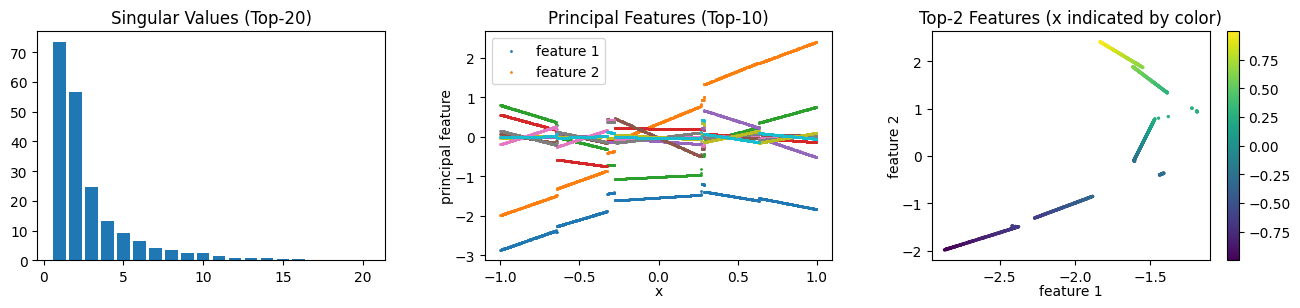

In [11]:
m, singular_values, principal_feature = svd_local_linearization(model)
visualize(m, singular_values, principal_feature)

The singular values have magnitudes in a reasonable range (but they aren’t all-distinct), indicating that the final gradients are stable. The uncontinuous shape of principal features indicates that we learned non-linear features, which are essential to capture the variability of the previous function.The fact that some principal features are on-top of each other and the non-distinct singular values suggest redundancy in learned features, this is probably due to the limited depth of the network, we will try to see how it looks for bigger depth (Effective rank-16)

## Training a Deeper Neural Network

In this section, we will train a deeper neural network with different weight scales for initialization. First, **define a fully-connected neural network with 4 hidden layers** and one ReLU activation after each layer except the last one, using the `nn.Sequential` API in PyTorch. Make sure that your model definition passes the assertions below.

In [12]:
# Define a neural network with 4 hidden layers
# and ReLU activation after each layer except the output layer

width = 20

model = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1)
)

assert len(model) == 9
assert sum(p.numel() for p in model.parameters()) == 1321
assert list(model(torch.randn(10, 1)).shape) == [10, 1]

### When the weight scale is too small...

The training of a deep neural network is highly impacted by the initialization of its parameters. Let's see what will happen if we initialize each entry in the weight matrices with random values drawn uniformly from the interval `[-0.03, 0.03]`.

In [13]:
# Initialize the neural network
def naive_init(scale, module):
    if isinstance(module, nn.Linear):
        nn.init.uniform_(module.weight, -scale, scale)
        nn.init.zeros_(module.bias)


np.random.seed(200)
torch.manual_seed(200)
model.apply(functools.partial(naive_init, 0.03))

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=1, bias=True)
)

In [14]:
def print_gnorms(model):
    batch_x = torch.from_numpy(train_x).float().unsqueeze(-1)
    batch_y = torch.from_numpy(train_y).float()
    pred = model(batch_x).view(-1)
    criterion = nn.MSELoss()
    loss = criterion(batch_y, pred)
    model.zero_grad()
    loss.backward()

    for name, param in model.named_parameters():
        if name.endswith(".weight"):
            with torch.no_grad():
                gnorm = torch.norm(param.grad, p = 2).item()
                print(name, "{:.8f}".format(gnorm))
print_gnorms(model)

0.weight 0.00000094
2.weight 0.00000106
4.weight 0.00000083
6.weight 0.00000133
8.weight 0.00000087


At the start of training, the norms of vectors are tiny, This is very undesirable as it means many of our units are dead from the start. These values are effectively zero and will lead to zero pre-activations.

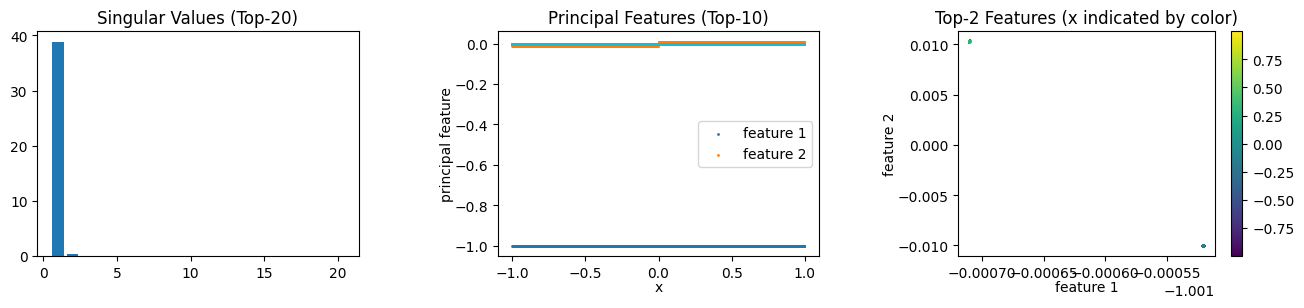

In [15]:
m, singular_values, principal_feature = svd_local_linearization(model)
visualize(m, singular_values, principal_feature)

At the start of the training, We only have two singular values; both are relatively small in magnitude compared to the previous network, they’re also highly disproportional.
When it comes to principal features, they’re parallel and on top of each other (They have approximately the same values), indicating symmetry.

In [16]:
principal_feature

array([[-1.00170994e+00,  1.02659073e-02,  6.15298973e-07, ...,
         4.03699840e-17,  2.08125375e-17,  1.20966541e-18],
       [-1.00152040e+00, -1.00511136e-02,  1.08276777e-06, ...,
        -4.59393745e-17, -1.11234617e-18, -5.15230579e-18],
       [-1.00170994e+00,  1.02659045e-02, -4.21096820e-06, ...,
         2.54333570e-17, -6.87083555e-18, -2.63625836e-17],
       ...,
       [-1.00152040e+00, -1.00511126e-02, -2.21817373e-07, ...,
         1.67041091e-18,  9.58997964e-18, -1.13763690e-18],
       [-1.00152040e+00, -1.00511117e-02, -1.20046866e-06, ...,
         5.62613635e-18,  1.83655106e-18,  4.33470806e-18],
       [-1.00170994e+00,  1.02659045e-02, -3.79399944e-06, ...,
         4.47608274e-18, -3.36648427e-18,  6.45104253e-19]], dtype=float32)

Then let's try to train this model.

{"step": 9, "train_loss": 0.162847101688385}
{"step": 19, "train_loss": 0.14070405066013336}
{"step": 29, "train_loss": 0.12274444848299026}
{"step": 39, "train_loss": 0.15820112824440002}
{"step": 46, "test_loss": 0.1449204385280609}
{"step": 49, "train_loss": 0.1598554253578186}
{"step": 59, "train_loss": 0.17037101089954376}
{"step": 69, "train_loss": 0.1300986409187317}
{"step": 79, "train_loss": 0.10837405920028687}
{"step": 89, "train_loss": 0.18736791610717773}
{"step": 93, "test_loss": 0.1309901624917984}
{"step": 99, "train_loss": 0.19114577770233154}
{"step": 109, "train_loss": 0.15881460905075073}
{"step": 119, "train_loss": 0.1423841118812561}
{"step": 129, "train_loss": 0.15911749005317688}
{"step": 139, "train_loss": 0.1651512235403061}
{"step": 140, "test_loss": 0.1452038586139679}
{"step": 149, "train_loss": 0.15185505151748657}
{"step": 159, "train_loss": 0.18214449286460876}
{"step": 169, "train_loss": 0.11275820434093475}
{"step": 179, "train_loss": 0.118945859372615

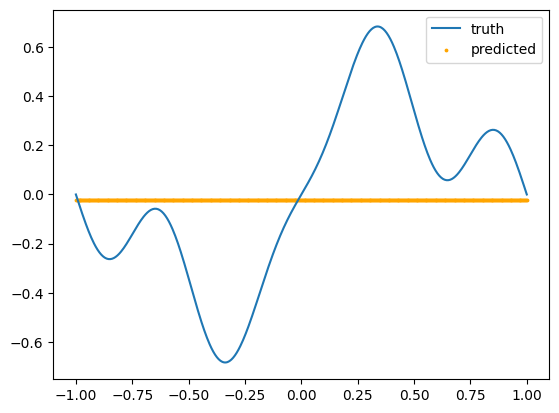

In [17]:
lr = 0.1
batch_size = 32
n_steps = int(TRAIN_N / batch_size * 10)

model, evaluated_x, evaluated_pred = train_model(model, n_steps, batch_size, lr, 250)

plt.figure()
plt.plot(test_x, f_true(test_x), label="truth")
plt.scatter(evaluated_x, evaluated_pred, s=3, c='orange', label="predicted")
plt.legend()
plt.show()

we can see how after training, with bad initialization, the resulting function is linear, and it doesn’t resemble the original function at all

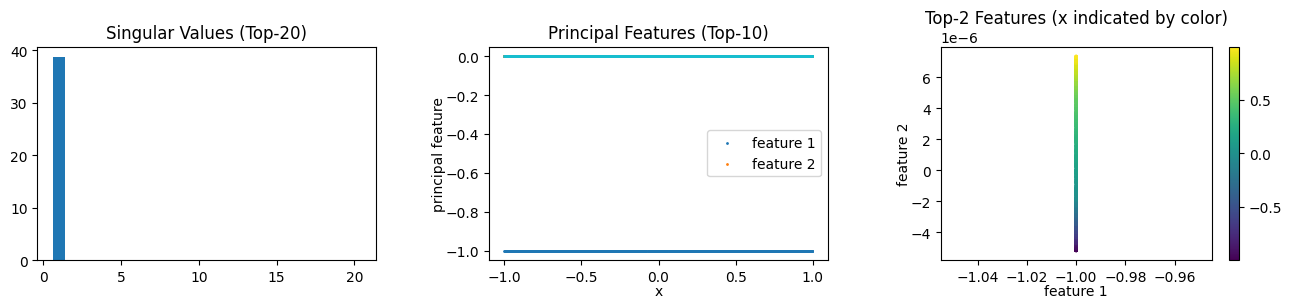

In [18]:
m, singular_values, principal_feature = svd_local_linearization(model)
visualize(m, singular_values, principal_feature)

After training, we have perfect symmetry with one singular value, which means our feature matrix collapsed to  rank-1 space and parallel principal features. The top-2 learned features are also linear, which doesn’t capture the necessary patterns and explains the linear approximation we had at the end. In deep nets, the product of small weights across layers causes activations to collapse to zero. Which essentially gives us one big linear function

In [19]:
principal_feature

array([[-1.00000000e+00,  4.77122057e-06,  3.27508758e-08, ...,
         5.32345234e-20, -9.25335386e-17,  2.12551801e-17],
       [-1.00000000e+00, -5.11113922e-06,  2.58551665e-07, ...,
        -1.34691962e-17, -1.16164257e-17, -5.47387349e-18],
       [-1.00000000e+00,  1.74997558e-06, -3.88000871e-07, ...,
        -1.66721181e-17,  1.74245761e-17,  3.99819238e-18],
       ...,
       [-1.00000000e+00, -3.43207148e-06,  5.38670513e-08, ...,
         5.80215385e-17,  1.44967973e-18, -4.26989143e-18],
       [-1.00000000e+00, -1.81458165e-06, -3.39905483e-07, ...,
         1.28240805e-17, -3.52549671e-18, -3.20229595e-18],
       [-1.00000000e+00,  2.05718061e-06, -3.88589456e-07, ...,
        -1.87084647e-17, -1.30194854e-17, -1.46076854e-17]], dtype=float32)

### When the weight scale is too large...

Let's see what will happen if we instead initialize each entry in the weight matrices with random values drawn uniformly from the interval `[-3.0, 3.0]`.

In [20]:
np.random.seed(300)
torch.manual_seed(300)
model.apply(functools.partial(naive_init, 3.0))

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=1, bias=True)
)

In [21]:
print_gnorms(model)

0.weight 65412.47656250
2.weight 50393.38281250
4.weight 48513.08203125
6.weight 139719.37500000
8.weight 177876.65625000


At initialization, the norms of vectors are huge; this is known as an exploding gradient due to the bad initialization of vectors, this leads to many problems (Skewed singular vales, Floating-point problems)

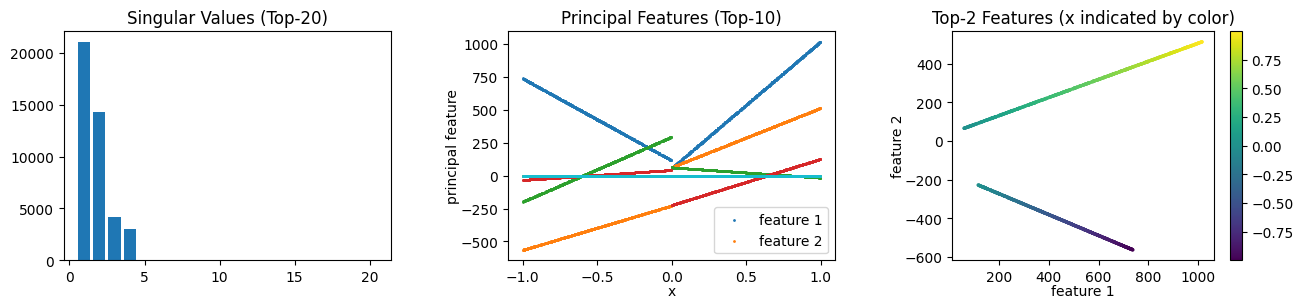

In [22]:
m, singular_values, principal_feature = svd_local_linearization(model)
visualize(m, singular_values, principal_feature)

We don't have the problem of symmetry again, the top-2 features are close to orthogonal, but we have huge singular values and a strong difference between the biggest and smallest singular values.

{"step": 9, "train_loss": NaN}
{"step": 19, "train_loss": NaN}
{"step": 29, "train_loss": NaN}
{"step": 39, "train_loss": NaN}
{"step": 46, "test_loss": NaN}
{"step": 49, "train_loss": NaN}
{"step": 59, "train_loss": NaN}
{"step": 69, "train_loss": NaN}
{"step": 79, "train_loss": NaN}
{"step": 89, "train_loss": NaN}
{"step": 93, "test_loss": NaN}
{"step": 99, "train_loss": NaN}
{"step": 109, "train_loss": NaN}
{"step": 119, "train_loss": NaN}
{"step": 129, "train_loss": NaN}
{"step": 139, "train_loss": NaN}
{"step": 140, "test_loss": NaN}
{"step": 149, "train_loss": NaN}
{"step": 159, "train_loss": NaN}
{"step": 169, "train_loss": NaN}
{"step": 179, "train_loss": NaN}
{"step": 187, "test_loss": NaN}
{"step": 189, "train_loss": NaN}
{"step": 199, "train_loss": NaN}
{"step": 209, "train_loss": NaN}
{"step": 219, "train_loss": NaN}
{"step": 229, "train_loss": NaN}
{"step": 234, "test_loss": NaN}
{"step": 239, "train_loss": NaN}
{"step": 249, "train_loss": NaN}
{"step": 259, "train_loss": 

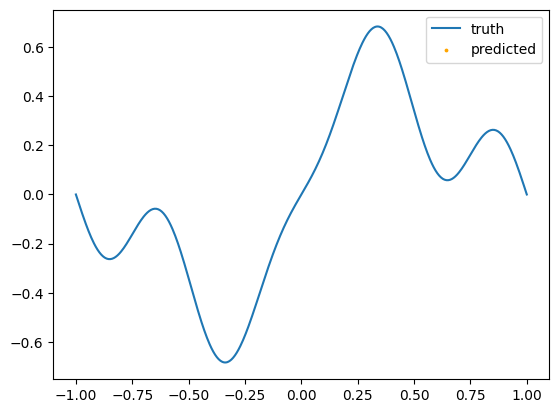

In [23]:
lr = 0.1
batch_size = 32
n_steps = int(TRAIN_N / batch_size * 10)

model, evaluated_x, evaluated_pred = train_model(model, n_steps, batch_size, lr, 350)

plt.figure()
plt.plot(test_x, f_true(test_x), label="truth")
plt.scatter(evaluated_x, evaluated_pred, s=3, c='orange', label="predicted")
plt.legend()
plt.show()

Due to huge gradients, we have Nan values due to overflow

### Better initialization methods

**Implement a better initialization method** based on what you have learned on this course.

HINT: a `module` with type `nn.Linear` has attributes `in_features` and `out_features`.

In [24]:
def better_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

np.random.seed(600)
torch.manual_seed(600)
model.apply(better_init)

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=1, bias=True)
)

In [25]:
print_gnorms(model)

0.weight 0.08497709
2.weight 0.31094936
4.weight 0.33647451
6.weight 0.40238914
8.weight 0.42149648


At initialization, the norms of gradients are very similar close to 0.4

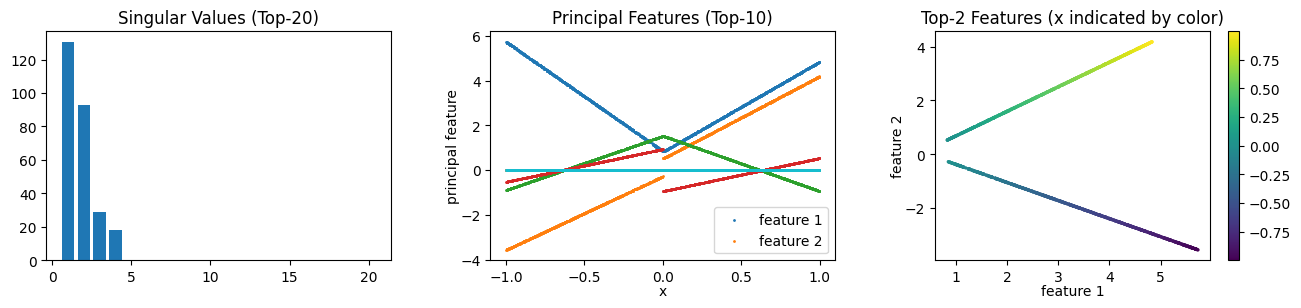

In [26]:
m, singular_values, principal_feature = svd_local_linearization(model)
visualize(m, singular_values, principal_feature)

Few singular values with appropriate differences of magnitude between them, the principal features are distinctive and the top-2 features are nearly orthogonal.  

{"step": 9, "train_loss": 0.06851601600646973}
{"step": 19, "train_loss": 0.03330112248659134}
{"step": 29, "train_loss": 0.015226814895868301}
{"step": 39, "train_loss": 0.023013833910226822}
{"step": 46, "test_loss": 0.016391796991229057}
{"step": 49, "train_loss": 0.03585299476981163}
{"step": 59, "train_loss": 0.02626059390604496}
{"step": 69, "train_loss": 0.02155313827097416}
{"step": 79, "train_loss": 0.016890425235033035}
{"step": 89, "train_loss": 0.023434879258275032}
{"step": 93, "test_loss": 0.011189782060682774}
{"step": 99, "train_loss": 0.013784101232886314}
{"step": 109, "train_loss": 0.011465905234217644}
{"step": 119, "train_loss": 0.03141292184591293}
{"step": 129, "train_loss": 0.02288958616554737}
{"step": 139, "train_loss": 0.02150099165737629}
{"step": 140, "test_loss": 0.010286500677466393}
{"step": 149, "train_loss": 0.012888874858617783}
{"step": 159, "train_loss": 0.013753790408372879}
{"step": 169, "train_loss": 0.01288989931344986}
{"step": 179, "train_loss

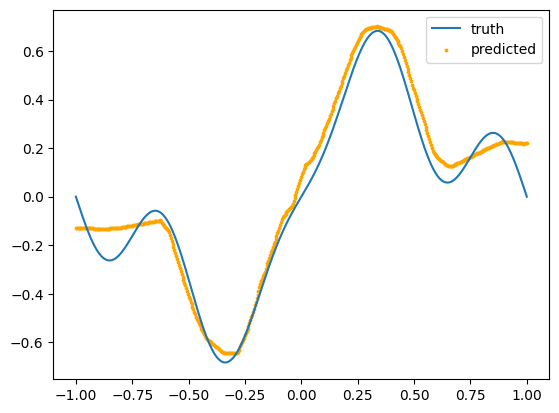

In [27]:
lr = 0.1
batch_size = 32
n_steps = int(TRAIN_N / batch_size * 10)

model, evaluated_x, evaluated_pred = train_model(model, n_steps, batch_size, lr, 650)

plt.figure()
plt.plot(test_x, f_true(test_x), label="truth")
plt.scatter(evaluated_x, evaluated_pred, s=3, c='orange', label="predicted")
plt.legend()
plt.show()

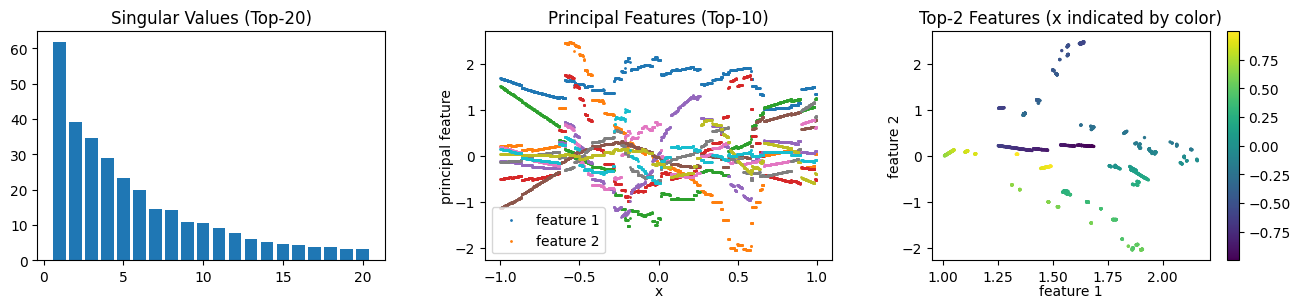

In [28]:
m, singular_values, principal_feature = svd_local_linearization(model)
visualize(m, singular_values, principal_feature)

We have learned non-linear features (Indicated by the uncontinuous shapes of the principal features); the final singular values have totally distinct values with reasonable differences in magnitude.

## Out-of-Distribution Generalization

In this section, we investigate the impact of mismatched data distributions on the performance of the neural network by generating a new training set with $x$ values sampled from the interval -1.0 to 0.4.

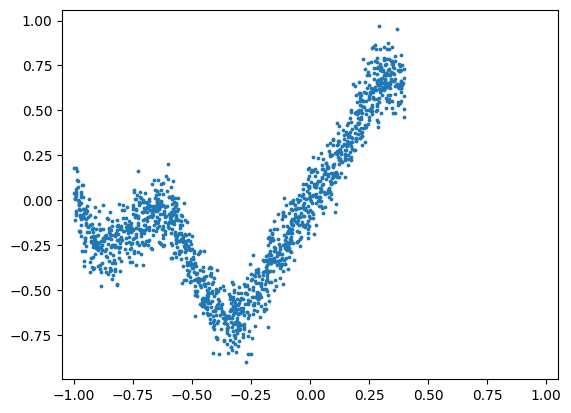

In [29]:
# Generate training data from -1 to 0.4
np.random.seed(50)
ood_train_x = np.random.uniform(low=-1.0, high=0.4, size=TRAIN_N)
ood_train_y = f_true(ood_train_x) + np.random.randn(TRAIN_N) * TRAIN_SIGMA

plt.figure()
plt.scatter(ood_train_x, ood_train_y, s=3)
plt.xlim(-1.05, 1.05)
plt.show()

In [30]:
np.random.seed(600)
torch.manual_seed(600)
model.apply(better_init)

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=1, bias=True)
)

{"step": 9, "train_loss": 0.03870955482125282}
{"step": 19, "train_loss": 0.021930821239948273}
{"step": 29, "train_loss": 0.0430363304913044}
{"step": 39, "train_loss": 0.038099244236946106}
{"step": 46, "test_loss": 0.3570568263530731}
{"step": 49, "train_loss": 0.027295436710119247}
{"step": 59, "train_loss": 0.017637772485613823}
{"step": 69, "train_loss": 0.019428055733442307}
{"step": 79, "train_loss": 0.01287657767534256}
{"step": 89, "train_loss": 0.008302946574985981}
{"step": 93, "test_loss": 0.34194353222846985}
{"step": 99, "train_loss": 0.015734508633613586}
{"step": 109, "train_loss": 0.02154342457652092}
{"step": 119, "train_loss": 0.014979427680373192}
{"step": 129, "train_loss": 0.014824282377958298}
{"step": 139, "train_loss": 0.008785917423665524}
{"step": 140, "test_loss": 0.39515677094459534}
{"step": 149, "train_loss": 0.012203939259052277}
{"step": 159, "train_loss": 0.016541318967938423}
{"step": 169, "train_loss": 0.025655921548604965}
{"step": 179, "train_loss

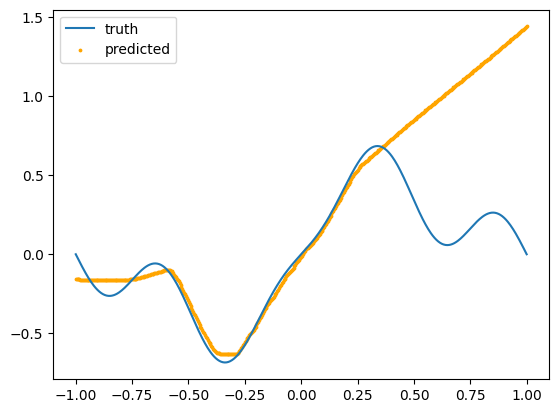

In [31]:
lr = 0.1
batch_size = 32
n_steps = int(TRAIN_N / batch_size * 10)

model, evaluated_x, evaluated_pred = train_model(model, n_steps, batch_size, lr, 650, ood_train_x, ood_train_y)

plt.figure()
plt.plot(test_x, f_true(test_x), label="truth")
plt.scatter(evaluated_x, evaluated_pred, s=3, c='orange', label="predicted")
plt.legend()
plt.show()

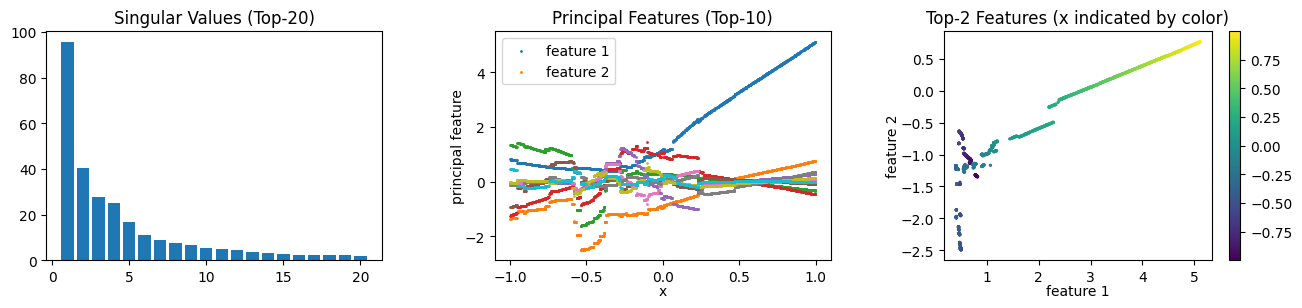

In [32]:
m, singular_values, principal_feature = svd_local_linearization(model)
visualize(m, singular_values, principal_feature)

Using out of range data leads to similiar performance with previous deep network in the included range, but we have linear performance in the out of range values,when x > 0.4 where there is no training data and almost all principal features degenerated to a straight line without any elbow, because we don't have x values that tip the elbows so they are just zero and collapse to a straight line.